In [1]:
%config InlineBackend.figure_format = 'retina'
from IPython.display import display, HTML
from nltk.corpus import stopwords as sw
from scipy import stats
from scipy.optimize import linear_sum_assignment
from sklearn import linear_model, preprocessing
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from string import punctuation
import matplotlib.pyplot as plt
import numpy as np
import nltk
import pandas as pd
import seaborn as sns

# A few usefull constants for plots
LABEL_FONT = 12
TITLE_FONT = 14

# Question 1: Propensity score matching

In [2]:
# Let's import the data
obs_df = pd.read_csv('lalonde.csv')
obs_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


## 1. A naive analysis

In [3]:
treated = obs_df[obs_df.treat == 1].re78
non_treated = obs_df[obs_df.treat == 0].re78

print("Let's take a look at a few properties of each distributions:")
print("Mean earnings in 1978 of the treated group:", treated.mean())
print("Mean earnings in 1978 of the non-treated group:", non_treated.mean())
print("Median earnings in 1978 of the treated group:", treated.median())
print("Median earnings in 1978 of the non-treated group:", non_treated.median())

Let's take a look at a few properties of each distributions:
Mean earnings in 1978 of the treated group: 6349.14353027
Mean earnings in 1978 of the non-treated group: 6984.16974231
Median earnings in 1978 of the treated group: 4232.309
Median earnings in 1978 of the non-treated group: 4975.505


At a first glance, it looks like the experiment did not really work out as the mean earnings of the treated group is smaller than the one of the untreated one, with the same median.

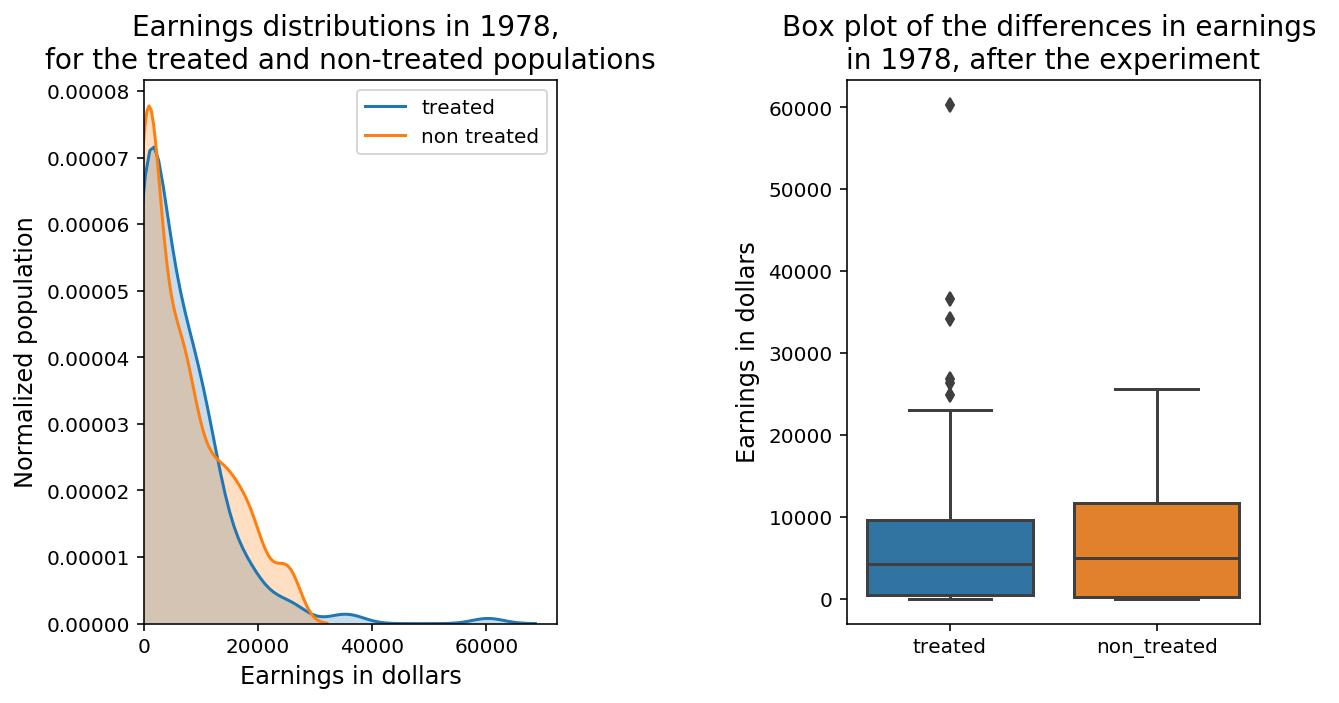

In [4]:
# Distributions of the two treated and non treated earnings in 78
f, (distrib, box) = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) 
f.subplots_adjust(wspace=0.7)

sns.kdeplot(treated, shade=True, label='treated', ax=distrib)
sns.kdeplot(non_treated, shade=True, label='non treated', ax=distrib)
distrib.set_title("Earnings distributions in 1978, \nfor the treated and non-treated populations", fontsize=TITLE_FONT)
distrib.set_ylabel("Normalized population", fontsize=LABEL_FONT)
distrib.set_xlabel("Earnings in dollars", fontsize=LABEL_FONT)
distrib.axes.set_xlim(0)

total = pd.concat([treated, non_treated], axis=1, ignore_index=True)
total.rename(columns={0:'treated', 1:'non_treated'}, inplace=True)
sns.boxplot(data=total, order=['treated', 'non_treated'], ax=box)
box.set_title("Box plot of the differences in earnings \nin 1978, after the experiment", fontsize=TITLE_FONT)
box.set_ylabel("Earnings in dollars", fontsize=LABEL_FONT)

plt.show()

We can observe the exact same thing by taking a look at the distributions and the box-plot of these earnings, it does not seem like the experiment worked in any way. 

In [5]:
statistic, pvalue = stats.ks_2samp(treated, non_treated)
print("We get the following results for the Kolmogorov-Smirnov test:")
print("Statistic:", statistic)
print("P-values:", pvalue)

We get the following results for the Kolmogorov-Smirnov test:
Statistic: 0.0986076986077
P-values: 0.152794522885


And as a follow up, the two sided Kolmogorov-Smirnov test shows that we cannot reject the hypothesis that the two distributions come from a third, common distribution. Hence there does not seem to be any positive effect of the experiment. Or is there ?

## 2. A closer look at the data

In [6]:
# Sets the treat as index
split_df = obs_df.set_index('treat')
split_df = split_df.rename(index={0: "non_treated", 1: "treated"})
split_df.index.name = None

### 2.1 Categorical data

For each categorical feature in the dataset (race, marriage and degree), we are going to compare its distribution in the treated group with its distribution in the control group.

As the features are categorical we are going to use barcharts. In fact, it seems to be the best method to compare and visualize those distributions.

In [7]:
# Are there any black AND hispanic people ?
race_df = split_df[['black', 'hispan']]
race_df[(race_df['black'] == 1) & (race_df['hispan'] == 1)].sum()

black     0.0
hispan    0.0
dtype: float64

We can see that there are no both hispanic and black people, thus the number of white people is simply the number of non-black and non-hispanic people.

In [8]:
# To not repeat too much code, we created a fast barchart method
def barchart(ordf, columnname, title, axis_drawn, race=False):
    '''
    Function that plots the bar chart for the categorical features we want.
    '''
    if race:
        df = ordf.copy()
        df[columnname[0]] = np.abs(ordf.sum(axis=1) - 1)
    else:
        df = pd.DataFrame(ordf[columnname[0]])
        df[columnname[1]] = np.abs(df[columnname[0]] - 1)
    df = df.groupby(df.index).sum()
    df = df.div(df.sum(axis=0), axis=1) * 100
    df.transpose().plot.bar(rot=0, title=title, ax=axis_drawn, fontsize=TITLE_FONT)
    axis_drawn.set_ylabel("percentage", fontsize=LABEL_FONT)


def bar_plot_analysis(df=split_df):
    f, (race_plt, marriage_plt, degree_plt) = plt.subplots(nrows=1, ncols=3, figsize=(15,5)) 
    f.subplots_adjust(wspace=0.8)

    race_df = df[['black', 'hispan']]
    race_df[(race_df['black'] == 1) & (race_df['hispan'] == 1)].sum()

    # We plot our barchart
    barchart(race_df, ['white'], 'Participants to the job training \nprogram according to their race', race_plt, race=True)
    barchart(df, ['married', 'not_married'], 'Participants to the job training \nprogram according to their marriage status', marriage_plt)
    barchart(df, ['nodegree', 'degree'], 'Participants to the job training \nprogram according to their school degree status', degree_plt)
    plt.show()

### Analysis

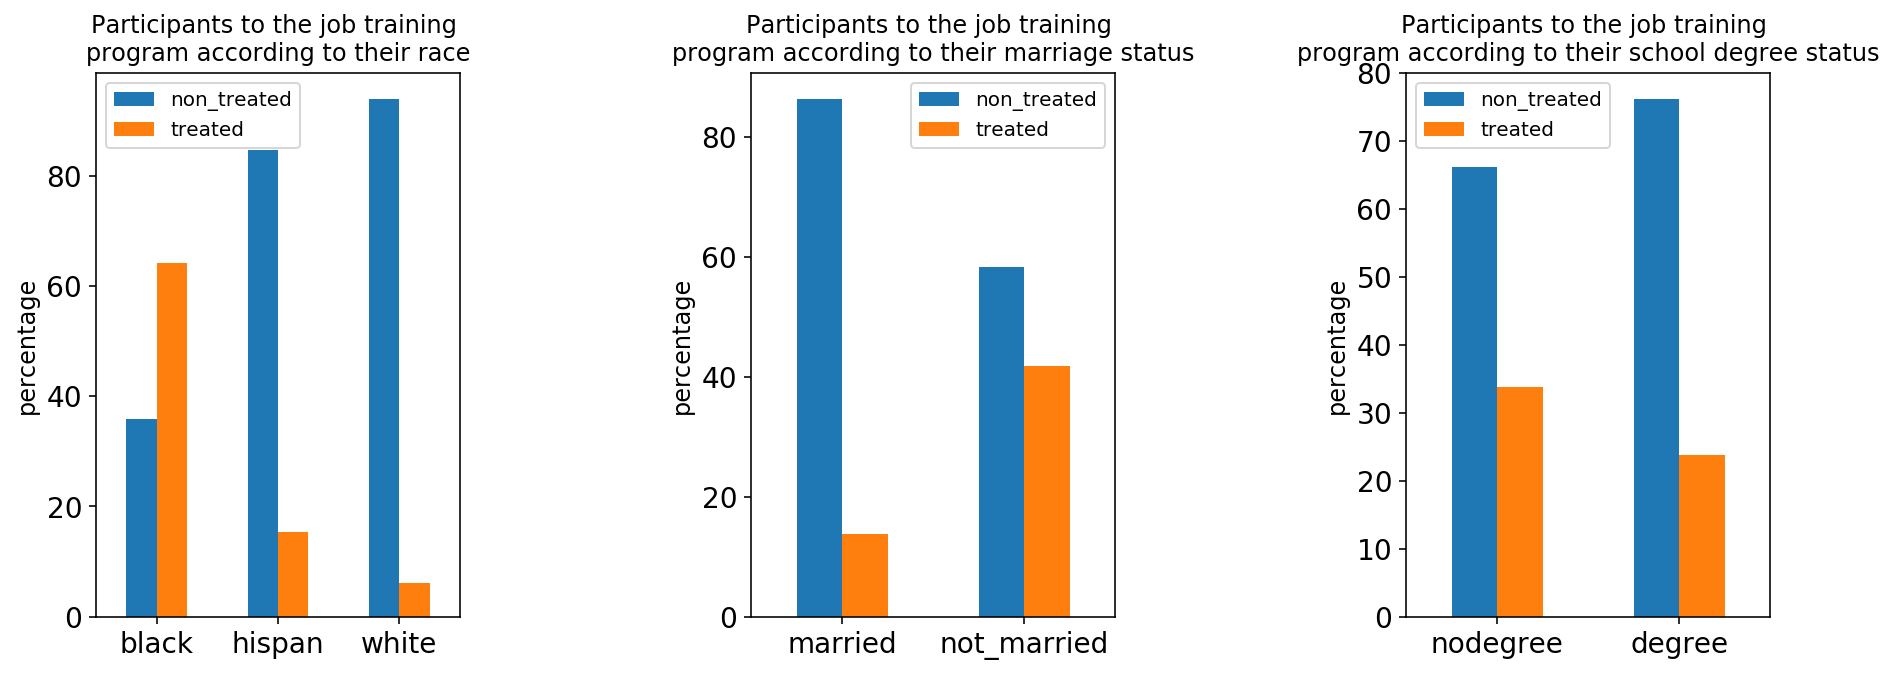

In [9]:
bar_plot_analysis(split_df)

As we can see, each race population has not been equally distributed between both groups. The whites and hispanics appear to have not been selected for the trial (most of them), which seems to be the contrary for black people.
Thus, we can see that the dataset is not really consistent according to the race population. It will be more readable and interesting if each race is equally represented in the two sets.

Again, taking a look at the married people, they seem to be more likely to be non-treated, however we cannot conclude anything regarding the not married ones as they appear to be more equally distributed.

It seems hard to conclude anything about the rate of people with or without degrees in the control group or in the experiment group as they seemed to be distributed the same way.

### 2.2 Continuous data

In [10]:
# We will mostly use the same way of plotting the continuous 
# data, hence the following functions will be usefull

def plot_distrib(column_name, title, xlabel, axis_drawn, df=split_df, ):
    """
    Plots the normalized distributions of treated 
    and non-treated populations of a certain given 
    column, and with a given title.
    """
    treated_dist, non_treated_dist = df.loc["treated"][column_name], df.loc["non_treated"][column_name]

    sns.kdeplot(treated_dist, shade=True, label='treated', ax=axis_drawn)
    sns.kdeplot(non_treated_dist, shade=True, label='non-treated', ax=axis_drawn)
    axis_drawn.legend(loc='upper right')
    axis_drawn.set_title(title, fontsize=TITLE_FONT)
    axis_drawn.set_xlabel(xlabel, fontsize=LABEL_FONT)
    axis_drawn.set_ylabel("Normalized population", fontsize=LABEL_FONT)
    axis_drawn.axes.set_xlim(0)
    
def box_plot(column_name, title, ylabel, axis_drawn, df=split_df):
    """
    Plots the box plot of treated and
    non-treated populations of a certain
    given column, with a given title.
    """
    treated = df[column_name].loc["treated"].reset_index().drop('index', axis=1)
    non_treated = df[column_name].loc["non_treated"].reset_index().drop('index', axis=1)
    total_df = pd.concat([treated, non_treated], ignore_index=True, axis=1)
    total_df.rename(columns={0:"treated", 1:"non_treated"}, inplace=True)

    sns.boxplot(data=total_df, order=['treated', 'non_treated'], ax=axis_drawn)
    axis_drawn.set_title(title, fontsize=TITLE_FONT)
    axis_drawn.set_ylabel(ylabel, fontsize=LABEL_FONT)
    
def stats_to_df(df=split_df):
    """
    Returns a new dataframe with the mean and median
    of each column of the continuous variables
    """
    grouped_df = df[['age', 'educ', 're74', 're75']].groupby(df.index)
    mean_df = pd.DataFrame(grouped_df.mean().unstack(), columns=['mean']).T
    median_df = pd.DataFrame(grouped_df.median().unstack(), columns=['median']).T
    return pd.concat([mean_df, median_df])
    
def KS_test(df=split_df):
    """
    Returns a dataframe with the Kolmogorov-Smirnov
    p-value for each column of the continuous
    variables
    """
    studied_columns = ['age', 'educ', 're74', 're75']
    data =  {}
    for column_name in studied_columns:
        _, p_value = stats.ks_2samp(df.loc["treated"][column_name], df.loc["non_treated"][column_name])
        data[column_name] = p_value
    return pd.DataFrame(data=data, index=['p-value'])

def plot_analysis(df=split_df):
    """
    Plots the complete analysis of the current dataframe
    to be able to visualize everything at once
    """
    f, (age, educ, re74, re75) = plt.subplots(nrows=4, ncols=2, figsize=(15,22.5)) 
    f.subplots_adjust(wspace=0.3, hspace=0.5)
    
    # Let's take a look at the distributions in the two groups
    plot_distrib("age", 'Age distribution of the \ntreated and non treated populations', "Age in years", age[0], df=df)
    box_plot('age', "Box plot of the ages for each category", "Age in years", age[1], df=df)
    plot_distrib("educ", 'Education years distribution of the \ntreated and non treated populations', "Education years", educ[0], df=df)
    box_plot('educ', "Box plot of the number of \neducation years for each category", "Education years", educ[1], df=df)
    plot_distrib("re74", 'Earnings distribution in 1974 of the \ntreated and non treated populations', "Earnings in dollars", re74[0], df=df)
    box_plot('re74', "Box plot of the earnings in 1974 \nin dollars for each category", "Earnings in dollars", re74[1], df=df)
    plot_distrib("re75", 'Earnings distribution in 1975 \nof the treated and non treated populations', "Earnings in dollars", re75[0], df=df)
    box_plot('re75', "Box plot of the earnings in 1975 \nin dollars for each category", "Earnings in dollars", re75[1], df=df)
    plt.show()

    display(stats_to_df(df))
    display(KS_test(df))

### Analysis

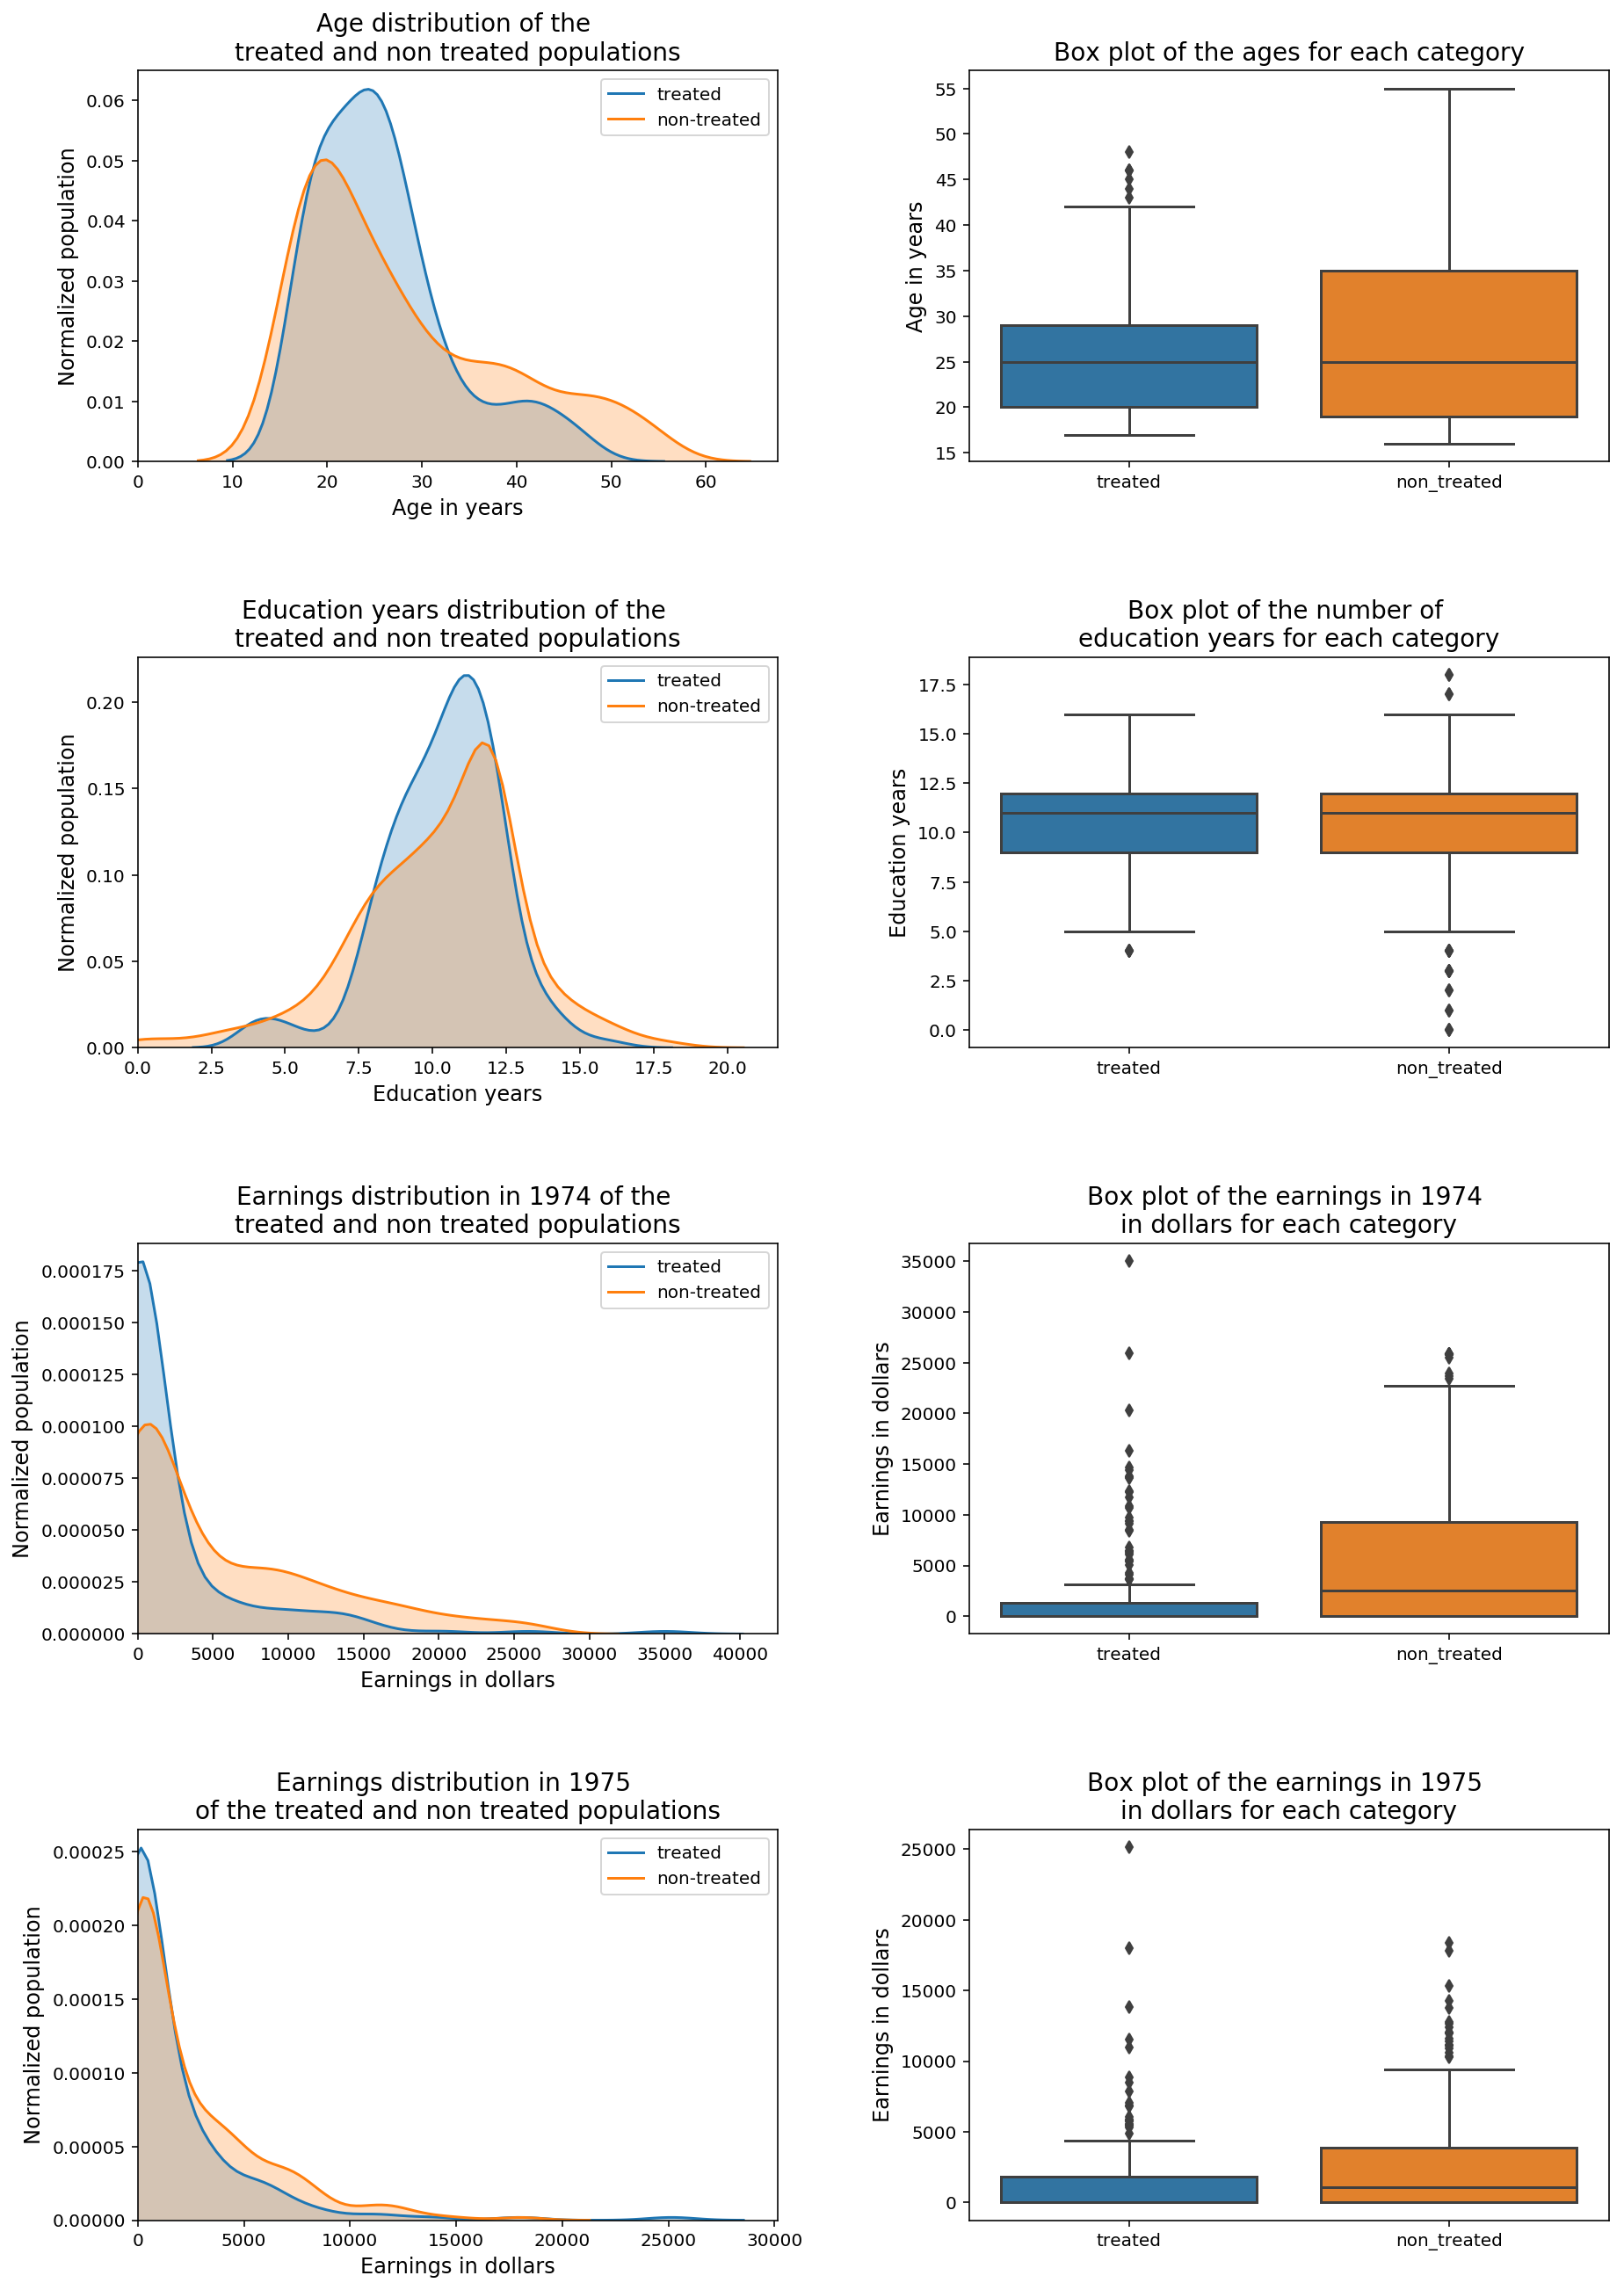

age                   educ                    re74  \
       non_treated    treated non_treated    treated  non_treated   
mean     28.030303  25.816216   10.235431  10.345946  5619.236506   
median   25.000000  25.000000   11.000000  11.000000  2547.047000   

                            re75               
            treated  non_treated      treated  
mean    2095.573689  2466.484443  1532.055314  
median     0.000000  1086.726000     0.000000

,age,educ,re74,re75
p-value,0.002779,0.075243,2.236440e-23,6.287076e-10


In [11]:
plot_analysis(split_df)

As we can clearly see, the study has been done on two similar age populations, however we can see that the age of the non-treated population has quite a higher variance compared to the other one. By taking a look at the p-value, we can see that it's lower than 5% which means that we can reject the hypothesis that the two samples come from the same distribution.

This time, with the education years, it seems like we have quite the same distributions which is good for analysis. Same goes for the p-value, we cannot reject the hypothesis that the samples come from the same distribution.

There is a huge difference inbetween the two groups in 1974, it seems like we have a poorer population for the treated ones, and a richer population for the non-treated one. We assume that they picked poorer people to be treated which would kind of make sense... However they heavily bias their split of the data. Moreover looking at the p-value we **definitely** reject the hypothesis that the samples come from the same distributions, which comforts the analysis that they split on the earnings into two groups.

We see the **exact** same thing for the earnings in 1975.

## 3. A propensity score model

In [12]:
logistic = linear_model.LogisticRegression()
#Get every features to train our model
train_df = obs_df.iloc[:, 2:-1]

# We need to standardize the data otherwise 
# the salaries will have way more impact
train_df = preprocessing.scale(train_df)

# Train the model
logistic.fit(y=obs_df.treat, X=train_df)

# Get the propensity scores
propensity_scores = logistic.predict_proba(X=train_df)[:,1]

# Let's check the accuracy
predict = logistic.predict(train_df)
print("We train with an accuracy of:", (predict == obs_df.treat).sum() / len(predict))

We train with an accuracy of: 0.824104234528


## 4. Balancing the dataset via matching

Let's try to balance out the dataset by matching one to one the people in each group.

In [13]:
# To apply the algorithm, we will need a joined DataFrame
# of matching ids, with their scores 
propensity_df = obs_df[['id','treat']].copy()
propensity_df['propensity_score'] = propensity_scores
treated_df = propensity_df.loc[propensity_df['treat'] == 1].copy()
untreated_df = propensity_df.loc[propensity_df['treat'] == 0].copy()
treated_df.drop('treat', axis=1, inplace=True)
untreated_df.drop('treat', axis=1, inplace=True)

# To facilitate the merging
treated_df['temp'] = 1
untreated_df['temp'] = 1

merge_df = pd.merge(treated_df, untreated_df, on='temp', suffixes=['_treated', '_untreated']).drop('temp', axis=1)

merge_df['abs_difference'] = np.abs(merge_df.propensity_score_treated - merge_df.propensity_score_untreated)
merge_df = merge_df.sort_values(by='abs_difference', ascending=True)
merge_df.set_index(['id_treated', 'id_untreated'], inplace=True)

# Here is the matrix of scores we will be using, each value is the
# absolute difference between the two propensity scores
edges_df = merge_df.copy()
edges_df = edges_df.abs_difference.reset_index()
edges_df = edges_df.pivot(index='id_treated', columns='id_untreated', values='abs_difference')
edges_df.head()

id_untreated,PSID1,PSID10,PSID100,PSID101,PSID102,PSID103,PSID104,PSID105,PSID106,PSID107,...,PSID90,PSID91,PSID92,PSID93,PSID94,PSID95,PSID96,PSID97,PSID98,PSID99
id_treated,,,,,,,,,,,,,,,,,,,,,
NSW1,0.605369,0.590957,0.493656,0.621732,0.547757,0.578174,0.610110,0.548093,0.540628,0.602140,...,0.559535,0.469623,0.587624,0.584184,0.170697,0.530681,0.116023,0.264484,0.181383,0.189763
NSW10,0.018575,0.004164,0.093137,0.034939,0.039037,0.008620,0.023316,0.038701,0.046166,0.015347,...,0.027258,0.117170,0.000830,0.002609,0.416097,0.056113,0.470771,0.322310,0.405410,0.397031
NSW100,0.220046,0.205635,0.108334,0.236410,0.162434,0.192852,0.224788,0.162771,0.155305,0.216818,...,0.174213,0.084301,0.202302,0.198862,0.214625,0.145358,0.269300,0.120839,0.203939,0.195560
NSW101,0.705783,0.691372,0.594071,0.722147,0.648171,0.678589,0.710525,0.648508,0.641042,0.702555,...,0.659950,0.570038,0.688039,0.684599,0.271112,0.631095,0.216437,0.364898,0.281798,0.290177
NSW102,0.711440,0.697029,0.599728,0.727804,0.653828,0.684245,0.716181,0.654164,0.646699,0.708212,...,0.665607,0.575695,0.693695,0.690256,0.276768,0.636752,0.222094,0.370555,0.287455,0.295834


To find the best possible matching, we simply use the [hungarian algorithm](https://en.wikipedia.org/wiki/Hungarian_algorithm) implemented in [scipy here](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.linear_sum_assignment.html) which is the exact same algorithm as used in networkx by the function max_weight_matching.

In [14]:
edges_np = edges_df.as_matrix()
treated_index, untreated_index = linear_sum_assignment(edges_np)

print("Here is the sum of the weights we had to minimize:", edges_np[treated_index, untreated_index].sum())

Here is the sum of the weights we had to minimize: 39.1528696054


It seems like we have a pretty good minimum weight matching considering the score. With a greedy configuration we could only come up with a minimum sum assignment of 40.19. Let us now select only the indices coming from this matching and do the analysis once again.

In [15]:
# Finally, we then keep the following data
matching_indices = edges_df.index[treated_index].tolist()
matching_indices.extend(edges_df.columns[untreated_index])
matched_df = obs_df[obs_df.id.isin(matching_indices)]
matched_df = matched_df.set_index('treat')
matched_df = matched_df.rename(index={0: "non_treated", 1: "treated"})
matched_df.index.name = None
matched_df.head()

,id,age,educ,black,hispan,married,nodegree,re74,re75,re78
treated,NSW1,37,11,1,0,1,1,0.0,0.0,9930.0460
treated,NSW2,22,9,0,1,0,1,0.0,0.0,3595.8940
treated,NSW3,30,12,1,0,0,0,0.0,0.0,24909.4500
treated,NSW4,27,11,1,0,0,1,0.0,0.0,7506.1460
treated,NSW5,33,8,1,0,0,1,0.0,0.0,289.7899


Let's redo the analysis we first did, using this new data of matchings.

### Analysis

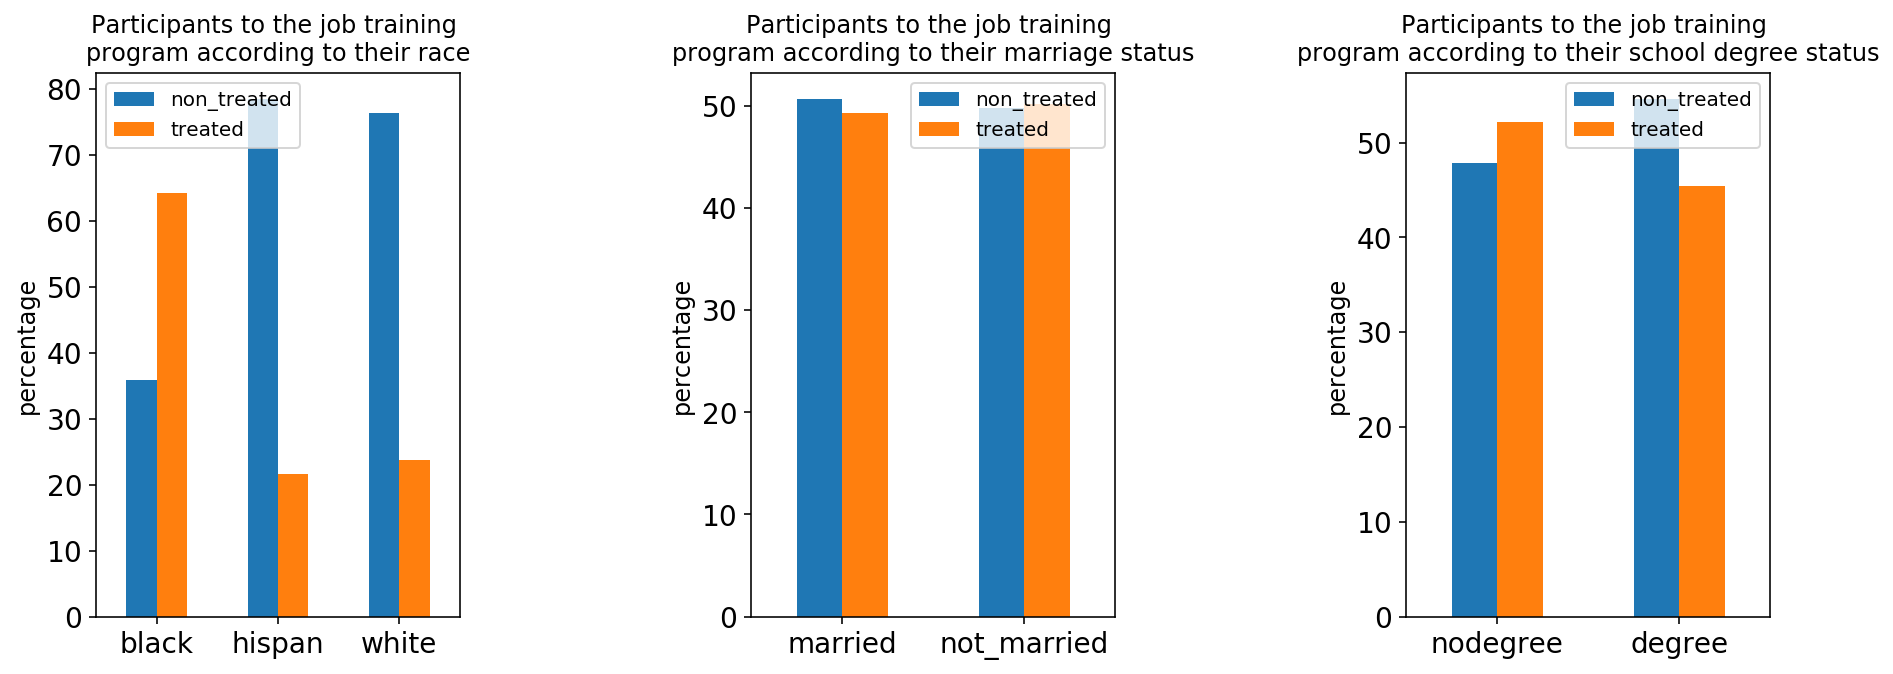

In [16]:
bar_plot_analysis(matched_df)

Now this is **much** better in terms of balancing out the dataset, we have something really balanced for the marriage and degrees, while still having some difficulties balancing out the race factor. The analysis will be way more accurate using this new dataset.

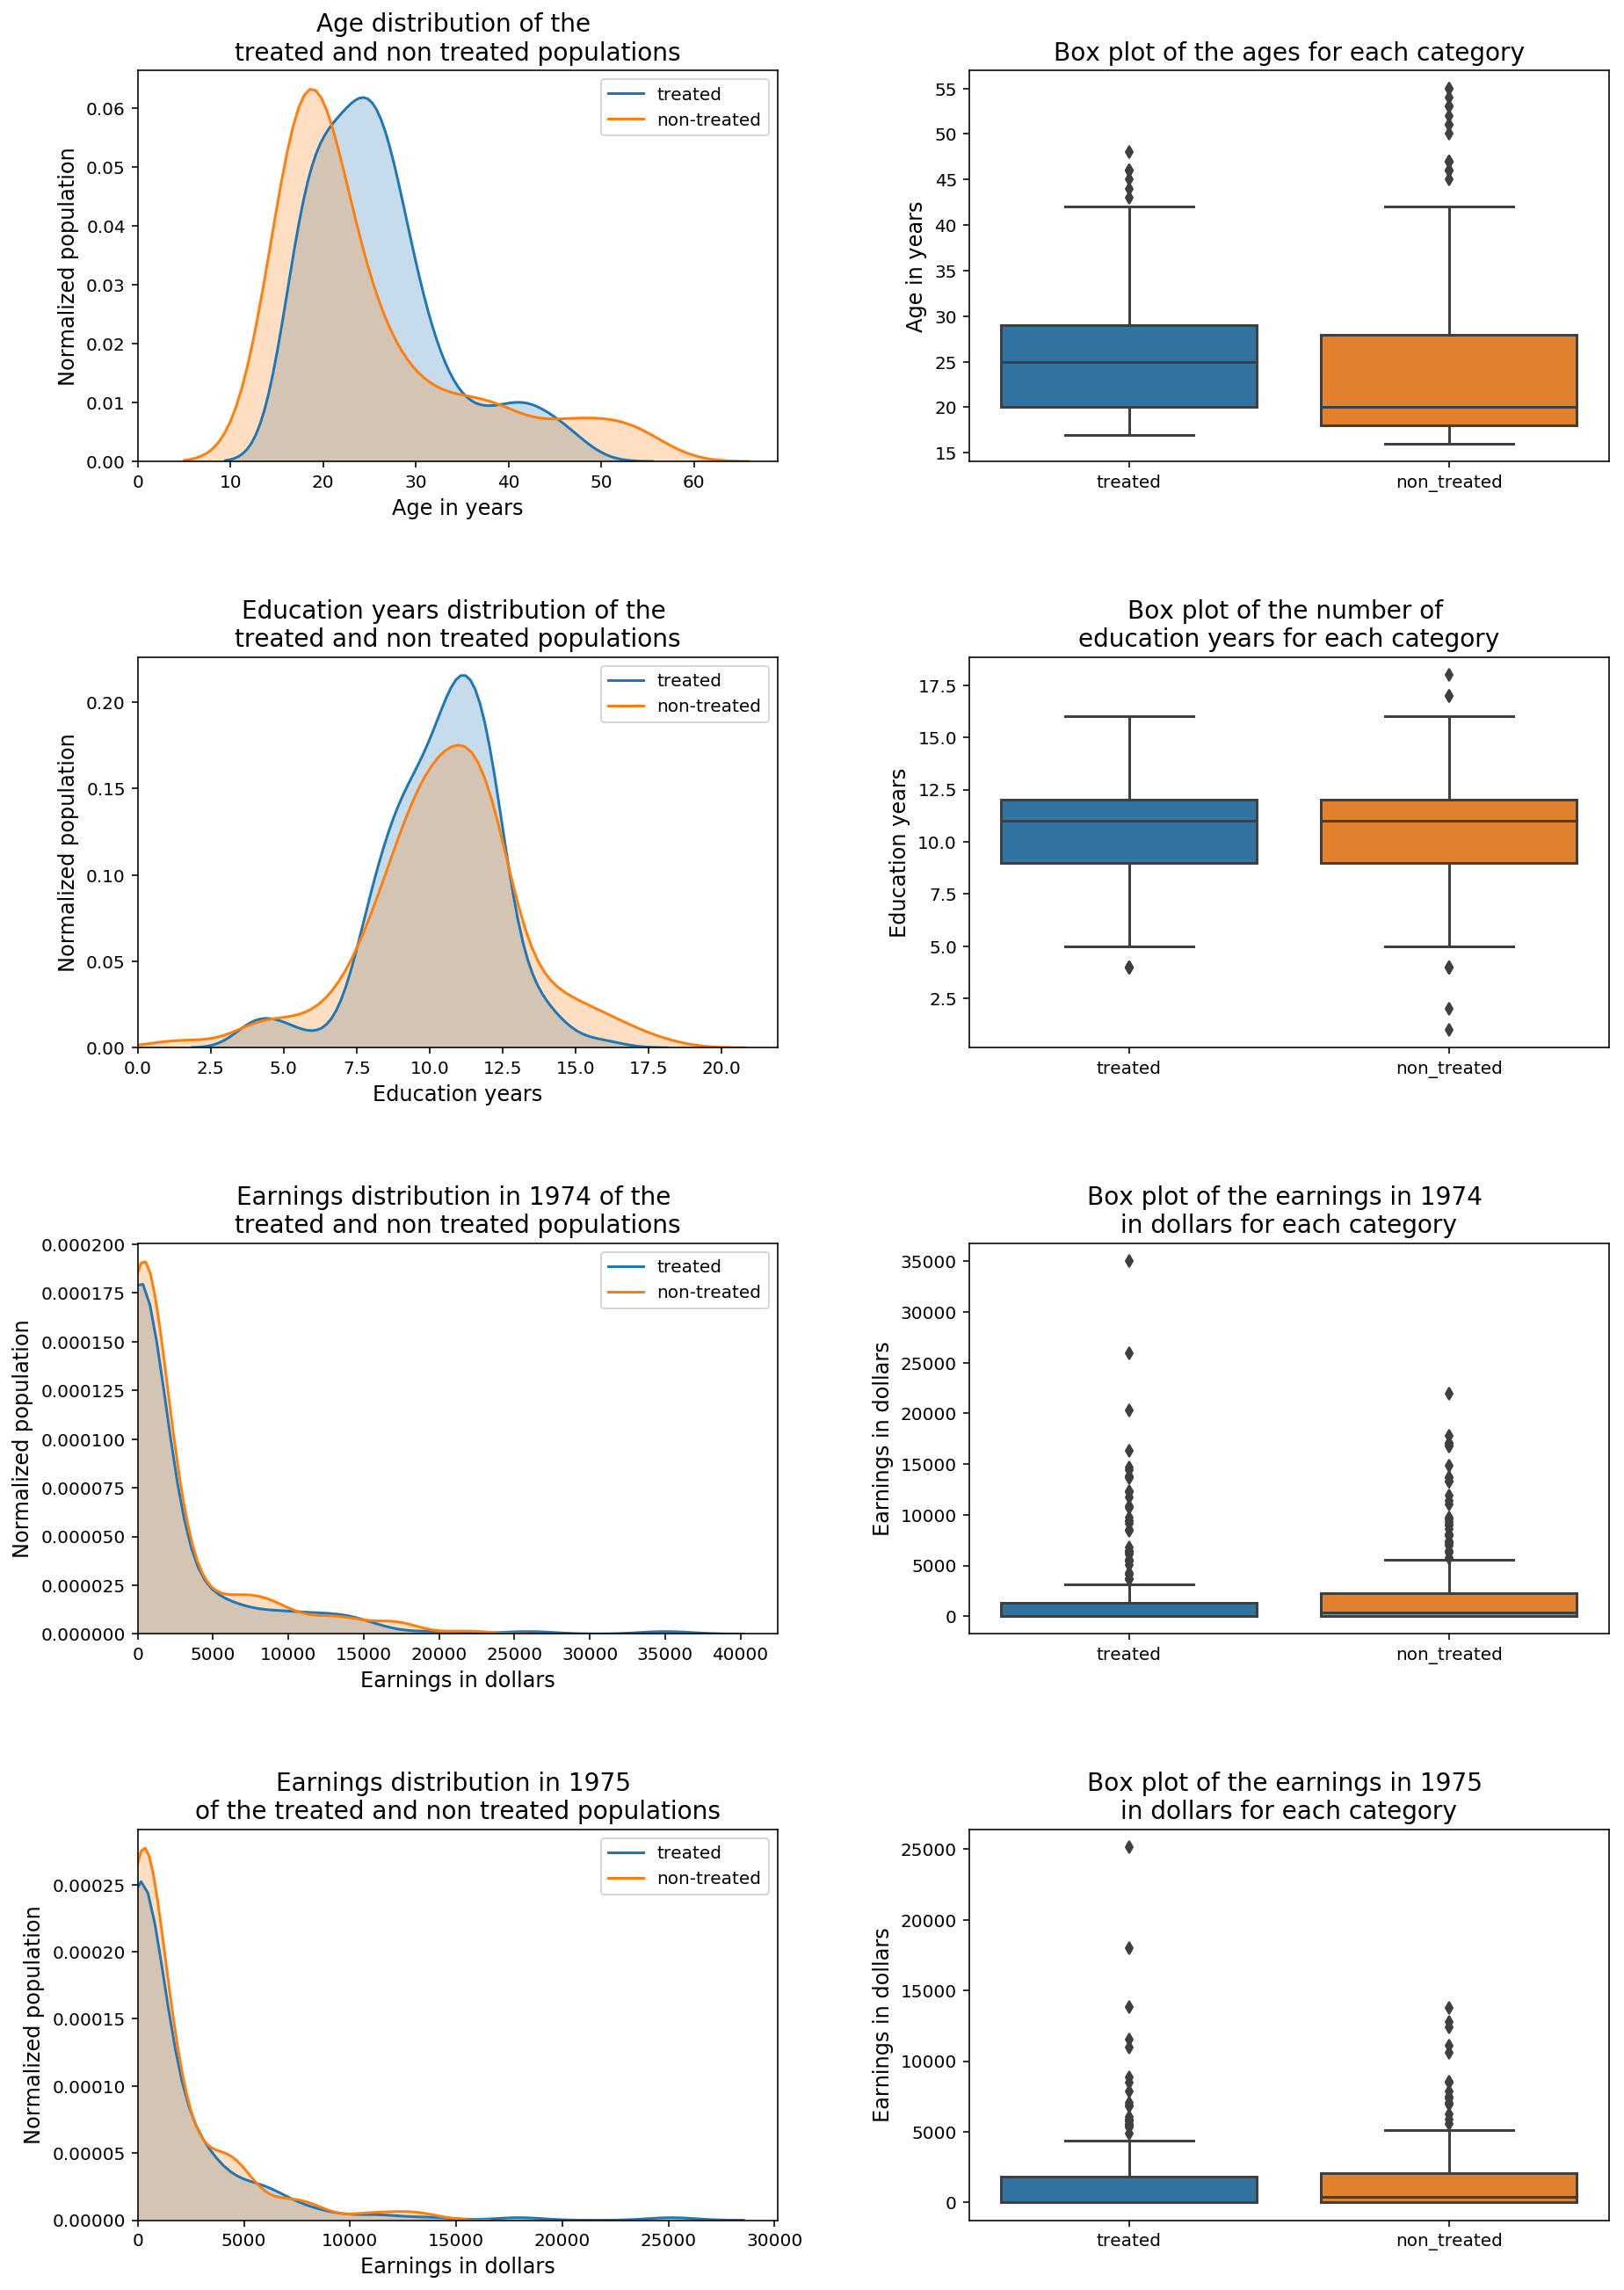

age                   educ                    re74  \
       non_treated    treated non_treated    treated  non_treated   
mean     24.972973  25.816216   10.508108  10.345946  2359.084331   
median   20.000000  25.000000   11.000000  11.000000   384.016300   

                            re75               
            treated  non_treated      treated  
mean    2095.573689  1639.635452  1532.055314  
median     0.000000   386.709700     0.000000

,age,educ,re74,re75
p-value,0.000002,0.818739,1.850247e-07,0.000276


In [17]:
plot_analysis(matched_df)

For all of the new distributions of age, education years and earnings, we have something with way less variance than we had before for the non-treated group before. Also the means are all closer to one another compared to before, especially concerning the earnings. 

This will definitely help us draw better conclusions from the experiment as we are comparing similar subjects in both datasets. However we still have to balance-out the race factor which remains a problem. This is what we're going to do now.

## 5. Balancing the groups further

So, knowing that the feature we need to balance is the race, and after taking a look at the count of each race, we decided to solve the problem the following way. We start by splitting the dataset into 3 dataFrames, one for each race. Then we match on a one to one basis using the Hungarian algorithm, just like before but this time on each of the dataFrames. Which means that we will get a smaller dataset, about two third of the previous one, which is not a huge cut. 

But by doing that we totally remove the bias on the race, and get a 50/50 split into two groups, and if the other variables remain similar, then we would have a really good matching to base our analysis off of.

In [18]:
def get_matching(df, race_stringed):
    """
    Returns the dataframe formed for the given
    race, after matching.
    """
    df = df.score.reset_index()
    df = df.pivot(index='id_treated', columns='id_untreated', values='score')
    edges_np = df.as_matrix()
    treated_index, untreated_index = linear_sum_assignment(edges_np)
    print("Here is the sum of the weights we had to minimize for the {} people: {}"
          .format(race_stringed, edges_np[treated_index, untreated_index].sum()))
    
    matching_indices = df.index[treated_index].tolist()
    matching_indices.extend(df.columns[untreated_index])
    
    matched_df = obs_df[obs_df.id.isin(matching_indices)]
    matched_df = matched_df.set_index('treat')
    matched_df = matched_df.rename(index={0: "non_treated", 1: "treated"})
    matched_df.index.name = None
    return matched_df

# To apply the algorithm, we will need a joined DataFrame
# of matching ids, with their scores 
propensity_df = obs_df[['id','treat', 'black', 'hispan']].copy()
propensity_df['propensity_score'] = propensity_scores
treated_df = propensity_df.loc[propensity_df['treat'] == 1].copy()
untreated_df = propensity_df.loc[propensity_df['treat'] == 0].copy()
treated_df.drop('treat', axis=1, inplace=True)
untreated_df.drop('treat', axis=1, inplace=True)

# To facilitate the merging
treated_df['temp'] = 1
untreated_df['temp'] = 1

merge_df = pd.merge(treated_df, untreated_df, on='temp', suffixes=['_treated', '_untreated']).drop('temp', axis=1)
merge_df['score'] = np.abs(merge_df.propensity_score_treated - merge_df.propensity_score_untreated)
merge_df = merge_df.sort_values(by='score', ascending=True)
merge_df.set_index(['id_treated', 'id_untreated'], inplace=True)

# Creating three dataFrames, one by race
black_df = merge_df[(merge_df.black_treated == 1) & (merge_df.black_untreated == 1)]
hispan_df = merge_df[(merge_df.hispan_treated == 1) & (merge_df.hispan_untreated == 1)]
white_df = merge_df[(merge_df.hispan_treated == 0) & (merge_df.hispan_untreated == 0) & (merge_df.black_treated == 0) & (merge_df.black_untreated == 0)]

# Once we have the three dataframes matched, we can combine 
# them into the final dataset that we will use for analysis.
corrected_matched_df = pd.concat([get_matching(black_df, "black"), 
                              get_matching(hispan_df, "hispanic"), 
                              get_matching(white_df, "white")])

print("The new dataframe contains now {} rows compared to the old matching which had {} rows"
      .format(corrected_matched_df.shape[0], matched_df.shape[0]))
corrected_matched_df.head()

Here is the sum of the weights we had to minimize for the black people: 1.0710706848414697
Here is the sum of the weights we had to minimize for the hispanic people: 0.026607861518972056
Here is the sum of the weights we had to minimize for the white people: 0.019082018571956877
The new dataframe contains now 232 rows compared to the old matching which had 370 rows


,id,age,educ,black,hispan,married,nodegree,re74,re75,re78
treated,NSW1,37,11,1,0,1,1,0.0,0.0,9930.046
treated,NSW7,23,12,1,0,0,0,0.0,0.0,0.000
treated,NSW8,32,11,1,0,0,1,0.0,0.0,8472.158
treated,NSW9,22,16,1,0,0,0,0.0,0.0,2164.022
treated,NSW11,19,9,1,0,0,1,0.0,0.0,8173.908


We have a new dataFrame that is not too far from the previous matched one in terms of data.

### Analysis

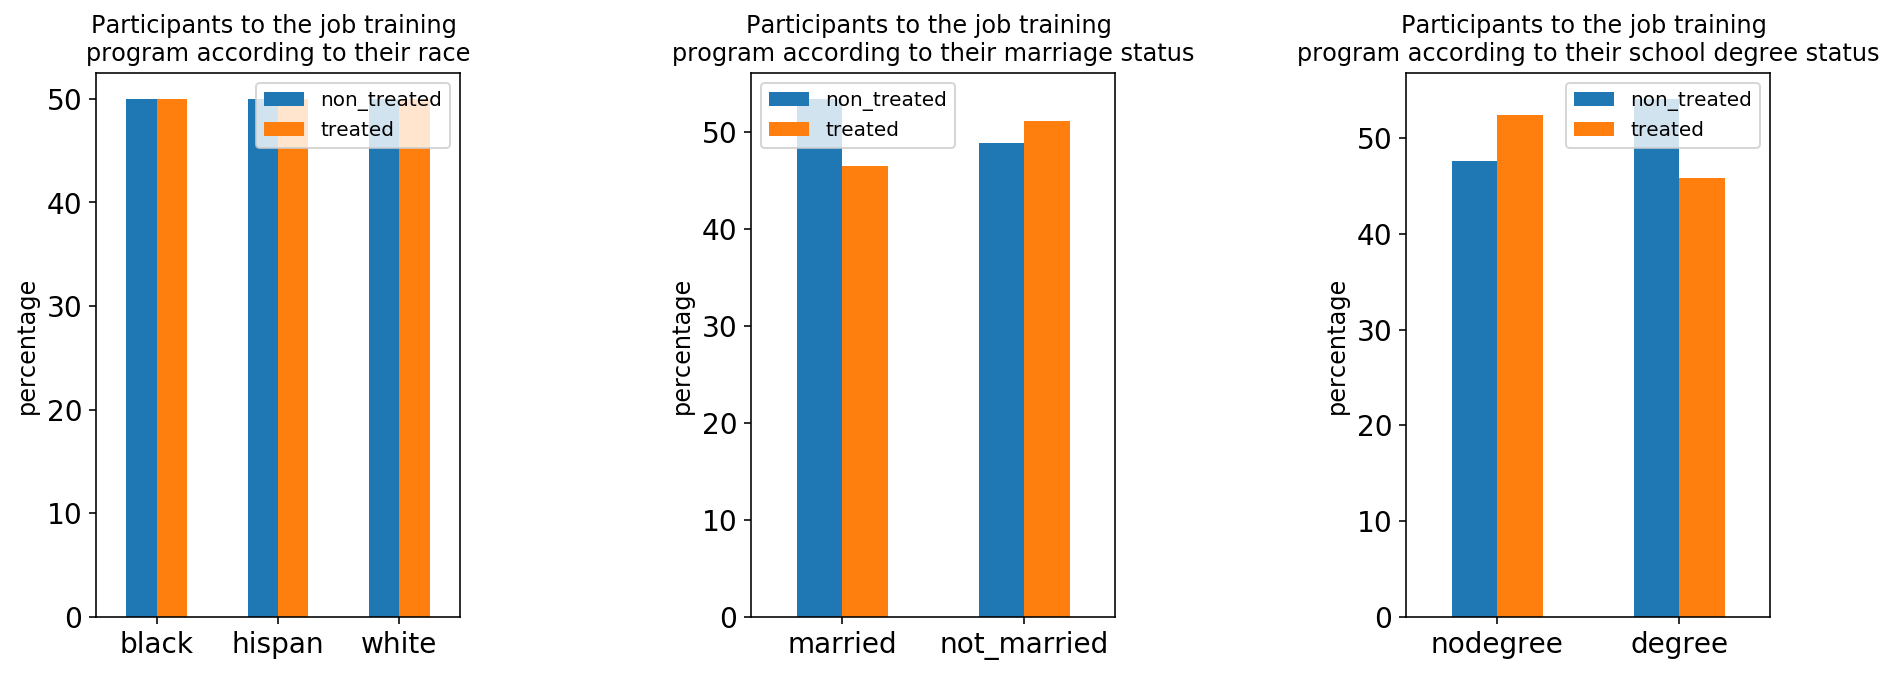

In [19]:
bar_plot_analysis(corrected_matched_df)

Awesome ! Now we have the three discrete variables all more or less distributed equally, which means that we will not have any bias regarding these variables. 

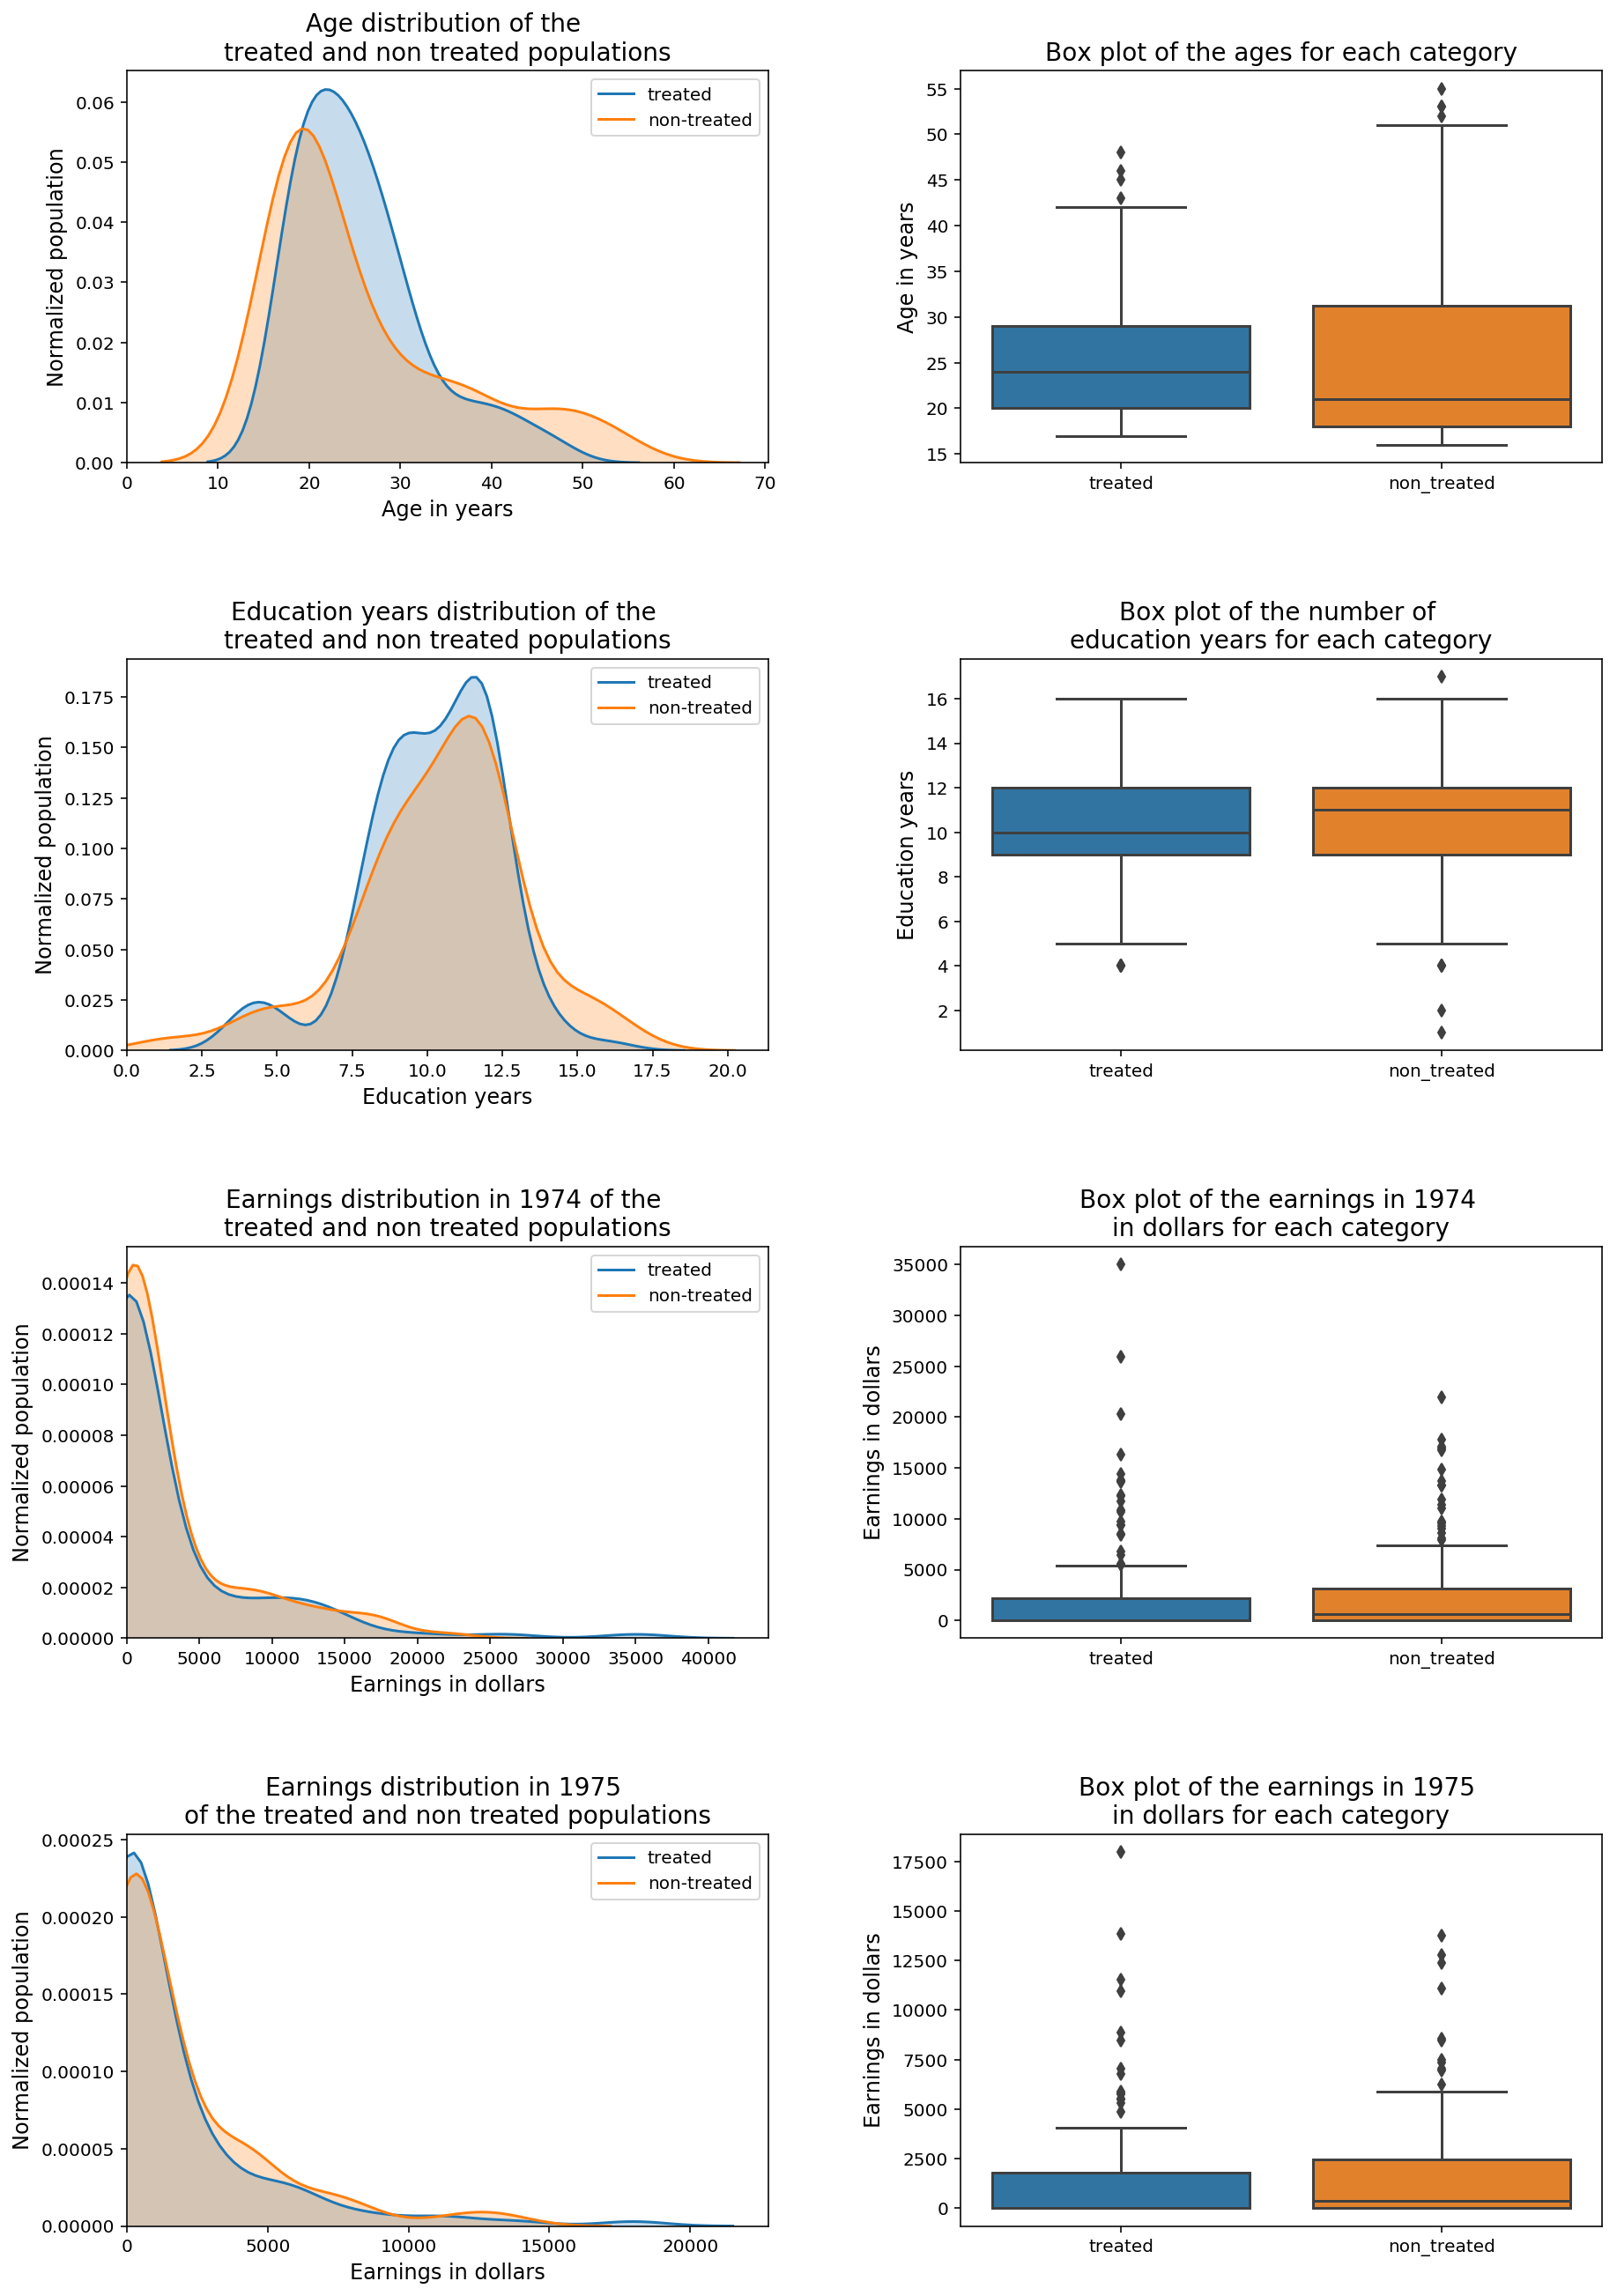

age                   educ                   re74               \
       non_treated    treated non_treated    treated non_treated      treated   
mean     25.931034  25.543103   10.413793  10.172414   2987.9157  2749.268406   
median   21.000000  24.000000   11.000000  10.000000    630.8839     0.000000   

               re75              
        non_treated     treated  
mean    1879.190415  1581.89678  
median   385.814500     0.00000

,age,educ,re74,re75
p-value,0.011688,0.980964,0.000214,0.151464


In [20]:
plot_analysis(corrected_matched_df)

The plots of the distributions of continuous variables did not change much, which means that our matching remains good overall, and now the analysis of the earnings in 1978 will be finally relevant !

## 6. A less naive analysis

Let's take a look at a few properties of each distributions:
Mean earnings in 1978 of the treated group: 6516.92976983
Mean earnings in 1978 of the non-treated group: 4891.21131853
Median earnings in 1978 of the treated group: 5130.7575
Median earnings in 1978 of the non-treated group: 2025.9634999999998


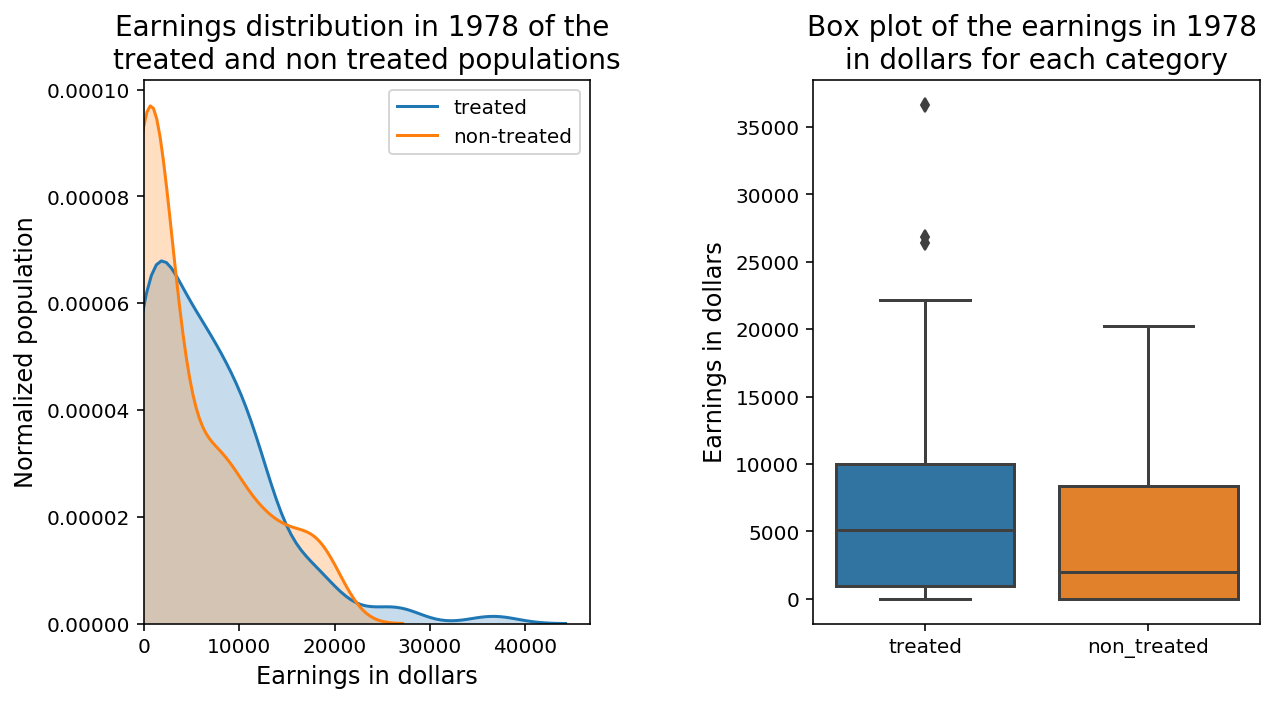

We get the following results for the Kolmogorov-Smirnov test:
Statistic: 0.215517241379
P-values: 0.00754633863401


In [21]:
# explain gone from trial if 0
treated = corrected_matched_df.loc['treated'].re78
non_treated = corrected_matched_df.loc['non_treated'].re78

print("Let's take a look at a few properties of each distributions:")
print("Mean earnings in 1978 of the treated group:", treated.mean())
print("Mean earnings in 1978 of the non-treated group:", non_treated.mean())

print("Median earnings in 1978 of the treated group:", treated.median())
print("Median earnings in 1978 of the non-treated group:", non_treated.median())

f, (re78_plt, re78_box) = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) 
f.subplots_adjust(wspace=0.5)

# Let's take a look at the distributions in the two groups
plot_distrib("re78", 'Earnings distribution in 1978 of the \ntreated and non treated populations', "Earnings in dollars", re78_plt, df=corrected_matched_df)
box_plot('re78', "Box plot of the earnings in 1978 \nin dollars for each category", "Earnings in dollars", re78_box, df=corrected_matched_df)
plt.show()

statistic, pvalue = stats.ks_2samp(treated, non_treated)
print("We get the following results for the Kolmogorov-Smirnov test:")
print("Statistic:", statistic)
print("P-values:", pvalue)

Now, that is more like it. We have matched on a one-to-one basis every subject in each group and only their earnings before and after the experiment differ. Now we are sure that analyzing the two distributions of treated and non-treated subjects is doable.

Doing so, we can see that by the mean and median, the treated group earns more than the non-treated group, which is also reflected by the distribution and boxplot we can see right away. The KS-test also confirms that the two distributions do **not** come from a common distribution.

The job training program works !

# Question 2: Applied ML

## 1. TF-IDF

We start by splitting the dataset in the training, testing and validation sets that we will be using later.

In [22]:
# Let's load up the dataset
dataset = fetch_20newsgroups(subset='all')

# Getting the train, test and validation indices
train_ind, test_ind = train_test_split(np.arange(len(dataset.data)), test_size=0.2)
validation_ind, test_ind = train_test_split(test_ind, test_size=0.5)

Preprocessing all of the articles by doing a few things to get a good set of features to compute TF-IDF on. Here is the list of preprocessing steps we took, for each article:
    - Removing the digits
    - Setting everything to lower-case
    - Removing the stop-words for the english language
    - Removing the punctuation
    - Stemming all the words
    
This preprocessing gives us a good list of usefull features on which we can apply TF-ID.

In [23]:
articles = dataset.data

# As discussed, we preprocess the data
def preprocess(data):
    stemmer = nltk.stem.porter.PorterStemmer()
    preprocessed = []
    print("Progression: {:.2f}%".format(00.00), end='\r')
    for count, each in enumerate(data):
        print("Progression: {:.2f}%".format((count + 1)/len(data)*100), end='\r')
        each = each.translate(str.maketrans('','','1234567890'))
        text = nltk.word_tokenize(each.lower())
        text = [word.translate(str.maketrans(' ', ' ', punctuation)) for word in text]
        text = [stemmer.stem(item) for item in text]
        text = [''.join(word) for word in text if word is not '']
        preprocessed.append(' '.join(text))
    return np.array(preprocessed)

articles = preprocess(articles)

# We build up a vectorizer to create our tf-idf matrix
vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english')
vectors = vectorizer.fit_transform(articles)

## 2. Random Forest
Let's now focus on finding the best parameters for the Random Forest using GridSearch. We use the validation set to do so. We tested on the full range of parameters from: 

    n_estimator in [3, 200]
    max_depth in [10, 140]
    
using a cluster, but in the following the show only the search for a lot less parameters in order to have a quick run to show the best parameters. The total run was saved in a `gridsearch_object.pkl` file right next to this notebook, if you want to take a look.

In [24]:
# Selecting the features for train, test and validation sets
train_features = vectors[train_ind]
test_features = vectors[test_ind]
validation_features = vectors[validation_ind]

train_labels = [dataset.target_names[x] for x in dataset.target[train_ind]]
test_labels = [dataset.target_names[x] for x in dataset.target[test_ind]]
validation_labels = [dataset.target_names[x] for x in dataset.target[validation_ind]]

# Using a Random Forest Classifier
ran_for_clas = RandomForestClassifier(n_jobs=3)

# We choose to focus on the following 
# range of parameters for the Grid Search
param_grid = { 
    'n_estimators': np.arange(170, 175, 1),
    'max_depth': np.arange(115, 130, 1)
}

# Let's fit the model using grid search
grid_search_rfc = GridSearchCV(estimator=ran_for_clas, param_grid=param_grid, cv=5, verbose=0)
grid_search_rfc.fit(validation_features, validation_labels)

# Taking a look at the best parameters
max_dp, n_est = grid_search_rfc.best_params_['max_depth'], grid_search_rfc.best_params_['n_estimators']
print("Hence, the best max_depth is {} and the best n_estimators is {}."
      .format(max_dp, n_est))

Hence, the best max_depth is 118 and the best n_estimators is 174.


The best parameters

Now that we found the best parameters, we can use them to fit a Random Forest Classifier on the training set, and then use the testing set to check the score and compute the confusion matrix.

In [25]:
# Let's run our chosen model and test it on the test set
best_rfc = RandomForestClassifier(max_depth=max_dp, n_estimators=n_est, n_jobs=3)

best_rfc.fit(train_features, train_labels)

score = best_rfc.score(test_features, test_labels)
print("We get a mean accuracy of: {}, which is pretty good !".format(score))

We get a mean accuracy of: 0.8710875331564987, which is pretty good !


Let's take a look at the confusion matrix:

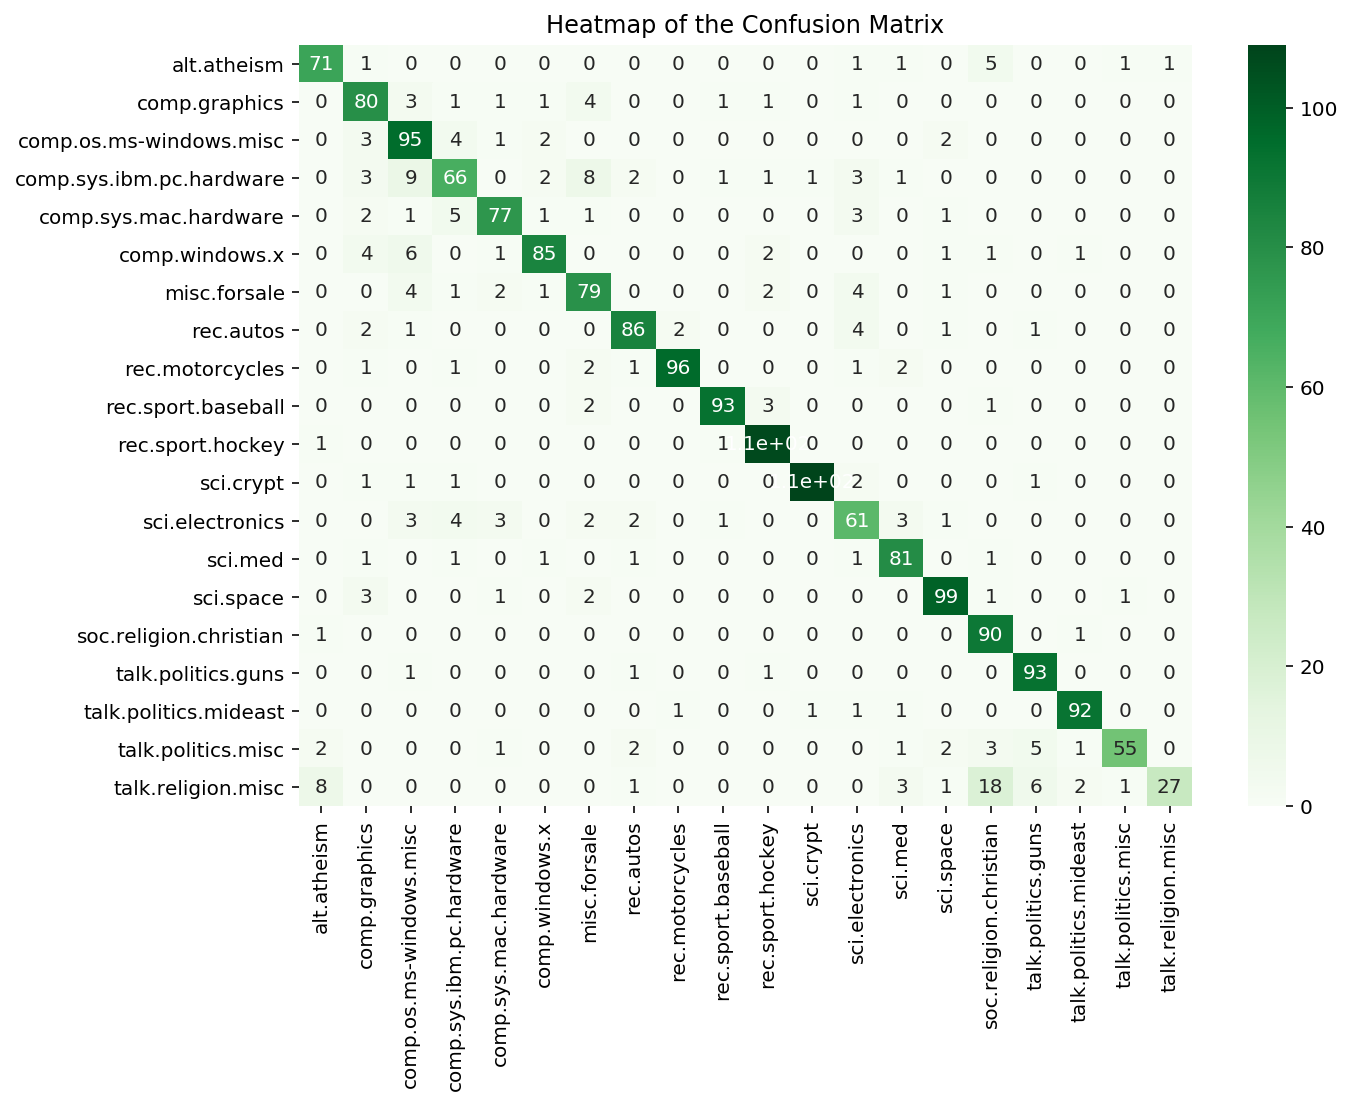

In [26]:
# Predicting labels using our model
test_pred_labels = best_rfc.predict(test_features)

# Creating the confusion matrix from our predictoins and the test labels
conf_matrix = confusion_matrix(test_labels, test_pred_labels, labels=dataset.target_names)
df_cm = pd.DataFrame(conf_matrix, columns=dataset.target_names, index=dataset.target_names)

# Let's plot it as a heatmap !
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="Greens")
plt.title('Heatmap of the Confusion Matrix')
plt.show()

We can directly see that we classify quite well on each label, the diagonal seems to be way different than the rest, hence we have more false negative and true positives.

But what about the most important features ?

In [27]:
# Choosing only the 30 best features
ind_max = np.argsort(best_rfc.feature_importances_)[::-1]
feature_name = np.array(vectorizer.get_feature_names())
print("Here are the thirty most important features: \n{}".format(', '.join(feature_name[ind_max[:30]])))

Here are the thirty most important features: 
car, sale, window, dod, bike, encrypt, game, clipper, space, hockey, god, christian, team, mac, key, gun, athosrutgersedu, appl, basebal, write, player, nhl, organ, isra, articl, ride, line, atheist, graphic, chip


As we can see, the most important features are words that would be the best to use in order to maximize the split for each branch of the tree, they are each really usefull to characterize into one of the labels. This makes total sense, and it shows that our classifier works really well ! 